# Preprocess GeoData from inflammation studies

Download the datasets from GEO and preprocess them into a common format as annotation data objects for downstream analysis.

### Setup

In [1]:
import GEOparse
from pprint import pprint
import anndata as ad
import numpy as np
from mygene import MyGeneInfo

In [2]:
DATA_DIR = "./data/geo_downloads"
OUTPUT_DIR = "./data/anndata"

GSE_IDs = {
    "HumanBurn": "GSE37069",
    "HumanTrauma": "GSE36809",
    "HumanSepsis": "GSE28750",
    "MouseBurn": "GSE7404",
    "MouseTrauma": "GSE7404",
    "MouseSepsis": "GSE19668",
    "MouseInfection": "GSE20524",
}

### Download data

In [3]:
gses = {}
for _, gse_id in GSE_IDs.items():
    gse = GEOparse.get_GEO(geo=gse_id, destdir=DATA_DIR)
    gses[gse_id] = gse

18-Sep-2025 13:41:06 DEBUG utils - Directory ./data/geo_downloads already exists. Skipping.
18-Sep-2025 13:41:06 INFO GEOparse - File already exist: using local version.
18-Sep-2025 13:41:06 INFO GEOparse - Parsing ./data/geo_downloads/GSE37069_family.soft.gz: 
18-Sep-2025 13:41:06 DEBUG GEOparse - DATABASE: GeoMiame
18-Sep-2025 13:41:06 DEBUG GEOparse - SERIES: GSE37069
18-Sep-2025 13:41:06 DEBUG GEOparse - PLATFORM: GPL570
/home/amoneim/.pyenv/versions/geneformer/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
18-Sep-2025 13:41:07 DEBUG GEOparse - SAMPLE: GSM909644
18-Sep-2025 13:41:07 DEBUG GEOparse - SAMPLE: GSM909645
18-Sep-2025 13:41:07 DEBUG GEOparse - SAMPLE: GSM909646
18-Sep-2025 13:41:07 DEBUG GEOparse - SAMPLE: GSM909647
18-Sep-2025 13:41:07 DEBUG GEOparse - SAMPLE: GSM909648
18-Sep-2025 13:41:07 DEBUG GEOparse

### Normalization and annotation functions

In [14]:
def process_geo_to_entrez(gse_obj, min_expr=4, min_frac=0.2,):
    """
    Process GEO microarray data into a gene x sample matrix using Entrez IDs.
    
    Parameters
    ----------
    gse_obj : GEOparse.GEO
        Parsed GEO object (from GEOparse.get_GEO).
    min_expr : float, optional
        Minimum log2 expression to consider a gene "expressed" in a sample.
    min_frac : float, optional
        Minimum fraction of samples that must pass `min_expr` for the gene to be kept.
    
    Returns
    -------
    exprs_gene : pd.DataFrame
        Expression DataFrame with Entrez IDs as index, samples as columns.
    """
    # Get expression matrix (probe x sample)
    exprs_df = gse_obj.pivot_samples('VALUE')
    exprs_df.columns = gse_obj.phenotype_data.index
    exprs_df.index.name = "ID_REF"

    # Load platform annotation
    platform_id = gse_obj.metadata['platform_id'][0]
    gpl_table = gse_obj.gpls[platform_id].table

    if "ENTREZ_GENE_ID" not in gpl_table.columns:
        raise ValueError("GPL table does not contain ENTREZ_GENE_ID column")

    # Build probe -> Entrez map
    probe_to_entrez = gpl_table.set_index("ID")["ENTREZ_GENE_ID"]

    # Merge annotation into expression
    exprs_df = exprs_df.join(probe_to_entrez, how="inner")
    exprs_df = exprs_df[exprs_df["ENTREZ_GENE_ID"].notna()]
    exprs_df["ENTREZ_GENE_ID"] = exprs_df["ENTREZ_GENE_ID"].astype(str)

    # Drop probes mapping to multiple genes (contain '///')
    exprs_df = exprs_df[~exprs_df["ENTREZ_GENE_ID"].str.contains("///")]

    # Remove whitespace
    exprs_df["ENTREZ_GENE_ID"] = exprs_df["ENTREZ_GENE_ID"].str.strip()

    # Collapse redundant probes
    exprs_gene = (
        exprs_df.drop(columns="ENTREZ_GENE_ID")
        .groupby(exprs_df["ENTREZ_GENE_ID"])
        .mean()
    )

    exprs_gene.index.name = "ENTREZ_GENE_ID"

    # filter lowly expressed genes
    min_samples = int(min_frac * exprs_gene.shape[1])
    exprs_gene = exprs_gene[exprs_gene.gt(min_expr).sum(axis=1) >= min_samples]

    return exprs_gene


In [15]:
def quantile_normalize(X: np.ndarray) -> np.ndarray:
    """
    Perform quantile normalization on a 2D numpy array (samples x genes)
    so that each sample ends up with the same distribution of values.
    
    Parameters
    ----------
    X : np.ndarray
        Input array of shape (samples, genes)
        
    Returns
    -------
    X_qn : np.ndarray
        Quantile-normalized array of the same shape
    """
    # Step 1: sort each sample (row) and get sorting indices
    sorted_idx = np.argsort(X, axis=1)
    sorted_X = np.sort(X, axis=1)
    
    # Step 2: compute rank-wise mean across samples
    mean_sorted = np.mean(sorted_X, axis=0)
    
    # Step 3: assign averaged ranks back to original positions
    X_qn = np.zeros_like(X)
    for i in range(X.shape[0]):  # for each sample
        X_qn[i, sorted_idx[i, :]] = mean_sorted
    
    return X_qn

In [6]:
def add_gene_metadata(adata, species="human"):
    """
    Add gene symbol and Ensembl ID to an existing AnnData object.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object with var_names = Entrez IDs
    species : str, default "human"
        Species for mygene query ("human" or "mouse")
    
    Returns
    -------
    adata : AnnData
        The same AnnData object with added .var["symbol"] and .var["ensembl_id"]
    """
    mg = MyGeneInfo()
    entrez_ids = adata.var_names.tolist()
    
    print(f"Querying MyGene.info for {len(entrez_ids)} genes...")
    results = mg.querymany(entrez_ids, scopes="entrezgene", fields=["symbol","ensembl.gene"], species=species)
    print("Query complete.")
    
    symbols = []
    ensembl_ids = []
    for r in results:
        symbol = r.get("symbol", None)
        ensembl = None
        if "ensembl" in r:
            if isinstance(r["ensembl"], list):
                ensembl = r["ensembl"][0].get("gene")
            else:
                ensembl = r["ensembl"].get("gene")
        symbols.append(symbol)
        ensembl_ids.append(ensembl)
    
    adata.var["symbol"] = symbols
    adata.var["ensembl_id"] = ensembl_ids
    
    return adata


### Workflow functions

In [7]:
def create_anndata(exprs_df, pheno_df, species="human"):
    """
    Create an AnnData object from expression and phenotype DataFrames.

    Applies normalization and metadata addition.
    
    Parameters
    ----------
    exprs_df : pd.DataFrame
        Expression DataFrame with genes as index, samples as columns.
    pheno_df : pd.DataFrame
        Phenotype DataFrame with samples as index, phenotypes as columns.
        
    Returns
    -------
    adata : AnnData
        AnnData object with .X = expression matrix, .obs = phenotype data, .var = gene metadata
    """
    adata = ad.AnnData(
        X=exprs_df.T,
        obs=pheno_df
    )

    # Apply quantile normalization
    adata.X = quantile_normalize(adata.X)
    adata = add_gene_metadata(adata, species=species)

    # assert no NaNs
    assert not np.isnan(adata.X).any(), "Data contains NaNs after processing"

    return adata

### Organize datasets into annotation data objects

#### Human burn

In [8]:
gsm = list(gses[GSE_IDs["HumanBurn"]].gsms.values())[-1]
pprint(gsm.metadata)

{'channel_count': ['1'],
 'characteristics_ch1': ['tissue: White blood cells',
                         'Sex: M',
                         'age: 2',
                         'hours_since_injury: 42.8'],
 'contact_address': ['55 Fruit Street, GRV 1302'],
 'contact_city': ['Boston'],
 'contact_country': ['USA'],
 'contact_department': ['Department of Surgery'],
 'contact_email': ['data_curator@gluegrant.org'],
 'contact_institute': ['Massachusetts General Hospital'],
 'contact_laboratory': ['Burn & Trauma Research'],
 'contact_name': ['Wenzhong Xiao,,,Inflammation & the Host Response to Injury'],
 'contact_phone': ['617 726 0082'],
 'contact_state': ['MA'],
 'contact_zip/postal_code': ['02114'],
 'data_processing': ['Affymetrix Power Tools version 1.8.6 RMA model'],
 'data_row_count': ['44692'],
 'description': ['b981108'],
 'extract_protocol_ch1': ['Total RNA was purified using the Rneasy RNA '
                          'Isolation kit standard protocol (Qiagen, Valencia, '
             

In [10]:
gse_obj = gses[GSE_IDs["HumanBurn"]]

exprs_df = process_geo_to_entrez(gse_obj)

# Prepare the phenotype data
pheno_df = gse_obj.phenotype_data[['source_name_ch1', 'characteristics_ch1.0.tissue', 'characteristics_ch1.1.Sex', 'characteristics_ch1.2.age', 'characteristics_ch1.3.hours_since_injury']]
pheno_df.columns = ['group', 'tissue', 'sex', 'age', 'time_point']

# Clean up 'group' and 'time_point' columns
pheno_df['group'] = pheno_df['group'].apply(lambda x: 'inflammation' if 'Subject' in x else 'control')
pheno_df['time_point'] = pheno_df['time_point'].str.extract('(\d+\.?\d*)').astype(float)
pheno_df['time_point'] = pheno_df['time_point'].fillna(0)

/tmp/ipykernel_741695/2324292919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['group'] = pheno_df['group'].apply(lambda x: 'inflammation' if 'Subject' in x else 'control')
/tmp/ipykernel_741695/2324292919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['time_point'] = pheno_df['time_point'].str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipykernel_741695/2324292919.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [11]:
human_burn_adata = create_anndata(exprs_df, pheno_df, species="human")

human_burn_adata.write_h5ad(f"{OUTPUT_DIR}/human_burn.h5ad")

Input sequence provided is already in string format. No operation performed


Querying MyGene.info for 17208 genes...


251 input query terms found no hit:	['100127972', '100128175', '100128185', '100128198', '100128298', '100128329', '100128644', '1001287


Query complete.


#### Human trauma

In [9]:
gsm = list(gses[GSE_IDs["HumanTrauma"]].gsms.values())[-1]
pprint(gsm.metadata)

{'channel_count': ['1'],
 'characteristics_ch1': ['tissue: White Blood Cells',
                         'Sex: F',
                         'age: 50',
                         'hours_since_injury: 108.9'],
 'contact_address': ['55 Fruit Street, GRV 1302'],
 'contact_city': ['Boston'],
 'contact_country': ['USA'],
 'contact_department': ['Department of Surgery'],
 'contact_email': ['data_curator@gluegrant.org'],
 'contact_institute': ['Massachusetts General Hospital'],
 'contact_laboratory': ['Burn & Trauma Research'],
 'contact_name': ['Wenzhong Xiao,,,Inflammation & the Host Response to Injury'],
 'contact_phone': ['617 726 0082'],
 'contact_state': ['MA'],
 'contact_zip/postal_code': ['02114'],
 'data_processing': ['Affymetrix Power Tools version 1.8.6 RMA model'],
 'data_row_count': ['54675'],
 'description': ['Please notice that this sample with low RNA quality.'],
 'extract_protocol_ch1': ['Total RNA was purified using the Rneasy RNA '
                          'Isolation kit stand

In [10]:
gse_obj = gses[GSE_IDs["HumanTrauma"]]
gse_obj.phenotype_data

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,...,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,series_id,data_row_count,relation
GSM901358,"Blood, control 22062194",GSM901358,Public on Mar 27 2012,Mar 26 2012,Mar 27 2012,RNA,1,Control,Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM901n...,GSE36809,44692,NaN
GSM901359,"Blood, control 4609399",GSM901359,Public on Mar 27 2012,Mar 26 2012,Mar 27 2012,RNA,1,Control,Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM901n...,GSE36809,44692,NaN
GSM901360,"Blood, control 8915966",GSM901360,Public on Mar 27 2012,Mar 26 2012,Mar 27 2012,RNA,1,Control,Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM901n...,GSE36809,44692,Reanalysis of: GSM287391
GSM901361,"Blood, control 17587105",GSM901361,Public on Mar 27 2012,Mar 26 2012,Mar 27 2012,RNA,1,Control,Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM901n...,GSE36809,44692,NaN
GSM901362,"Blood, control 1829766",GSM901362,Public on Mar 27 2012,Mar 26 2012,Mar 27 2012,RNA,1,Control,Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM901n...,GSE36809,44692,Reanalysis of: GSM287392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1639940,"Blood, Subject 30335589, hours since injury 32.8",GSM1639940,Public on Mar 22 2015,Mar 21 2015,Mar 22 2015,RNA,1,"Subject 30335589, hours since injury 32.8",Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1639...,GSE36809,54675,NaN
GSM1639941,"Blood, Subject 30335589, hours since injury 107.3",GSM1639941,Public on Mar 22 2015,Mar 21 2015,Mar 22 2015,RNA,1,"Subject 30335589, hours since injury 107.3",Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1639...,GSE36809,54675,NaN
GSM1639942,"Blood, Subject 30335589, hours since injury 176.9",GSM1639942,Public on Mar 22 2015,Mar 21 2015,Mar 22 2015,RNA,1,"Subject 30335589, hours since injury 176.9",Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1639...,GSE36809,54675,NaN
GSM1639943,"Blood, Subject 33132122, hours since injury 33.7",GSM1639943,Public on Mar 22 2015,Mar 21 2015,Mar 22 2015,RNA,1,"Subject 33132122, hours since injury 33.7",Homo sapiens,9606,...,Massachusetts General Hospital,"55 Fruit Street, GRV 1302",Boston,MA,02114,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1639...,GSE36809,54675,NaN


In [11]:
# check the data_row_count column, how many values and how many of each
gse_obj.phenotype_data['data_row_count'].value_counts()

data_row_count
44692    812
54675     45
Name: count, dtype: int64

New samples have more genes, so we will filter to the common genes between the two datasets.

In [16]:
exprs_df = process_geo_to_entrez(gse_obj)

# Prepare the phenotype data
pheno_df = gse_obj.phenotype_data[['source_name_ch1', 'characteristics_ch1.0.tissue', 'characteristics_ch1.1.Sex', 'characteristics_ch1.2.age', 'characteristics_ch1.3.hours_since_injury']]
pheno_df.columns = ['group', 'tissue', 'sex', 'age', 'time_point']

# Clean up 'group' and 'time_point' columns
pheno_df['group'] = pheno_df['group'].apply(lambda x: 'inflammation' if 'Subject' in x else 'control')
pheno_df['time_point'] = pheno_df['time_point'].str.extract('(\d+\.?\d*)').astype(float)
pheno_df['time_point'] = pheno_df['time_point'].fillna(0)

# remove rows with any NaN values in exprs_df
exprs_df = exprs_df.dropna()

/tmp/ipykernel_748909/878343256.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['group'] = pheno_df['group'].apply(lambda x: 'inflammation' if 'Subject' in x else 'control')
/tmp/ipykernel_748909/878343256.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['time_point'] = pheno_df['time_point'].str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipykernel_748909/878343256.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [17]:
exprs_df

,GSM901358,GSM901359,GSM901360,GSM901361,GSM901362,GSM901363,GSM901364,GSM901365,GSM901366,GSM901367,...,GSM1639935,GSM1639936,GSM1639937,GSM1639938,GSM1639939,GSM1639940,GSM1639941,GSM1639942,GSM1639943,GSM1639944
ENTREZ_GENE_ID,,,,,,,,,,,,,,,,,,,,,
1,2.909180,3.257720,2.867890,3.018440,3.583810,3.030070,3.371740,3.250960,3.050470,3.089860,...,5.435670,5.266520,5.834010,6.002590,5.887680,6.017160,5.882330,5.921940,5.716150,5.610420
10,3.148280,2.737330,3.355190,3.222010,2.852290,2.962600,2.882490,2.894490,2.788960,2.760650,...,5.183610,5.158510,4.865350,5.002680,5.217080,4.941490,5.063320,5.109140,5.099580,5.143620
100,4.739230,5.494065,4.644720,5.034870,4.838395,4.184675,4.527845,4.630795,4.636025,4.935060,...,6.835005,5.963445,6.487700,5.907635,6.024605,6.780780,7.766150,6.240735,5.988030,7.573205
1000,2.919380,3.040460,2.835050,3.267335,3.331630,3.171820,3.451315,3.464000,2.952125,2.933250,...,4.790970,4.903145,4.665595,4.713590,4.810075,4.473370,4.794485,4.966900,5.271380,4.699920
10000,3.482064,3.287349,3.216259,3.383900,3.257920,3.280783,3.478573,3.656166,3.228420,3.236033,...,5.112949,4.925836,4.746896,4.696970,4.666406,4.908810,4.992946,4.666649,4.598449,4.949913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,7.396690,7.332456,7.444774,6.406886,6.692618,7.696404,6.727674,7.075518,7.693852,7.526548,...,9.067514,8.980370,8.711868,8.866860,8.715314,8.635388,8.486700,9.253444,9.325954,8.809510
9992,3.235180,3.295850,3.650610,4.215600,3.446980,3.522840,3.074090,3.345940,3.735900,3.566410,...,6.288240,6.231380,5.755840,5.565550,5.567270,5.678330,5.962110,6.487570,6.039190,5.933650
9993,6.495030,6.034875,6.743250,6.243025,6.276745,6.273645,6.227100,6.186200,6.274840,6.370540,...,7.872190,7.909845,8.343480,8.239070,8.233670,8.202765,8.098085,8.574635,8.771245,8.381700


In [18]:
pheno_df

,group,tissue,sex,age,time_point
GSM901358,control,White Blood Cells,M,27,0.0
GSM901359,control,White Blood Cells,F,41,0.0
GSM901360,control,White Blood Cells,F,18,0.0
GSM901361,control,White Blood Cells,F,51,0.0
GSM901362,control,White Blood Cells,M,26,0.0
...,...,...,...,...,...
GSM1639940,inflammation,White Blood Cells,F,43,32.8
GSM1639941,inflammation,White Blood Cells,F,43,107.3
GSM1639942,inflammation,White Blood Cells,F,43,176.9
GSM1639943,inflammation,White Blood Cells,F,46,33.7


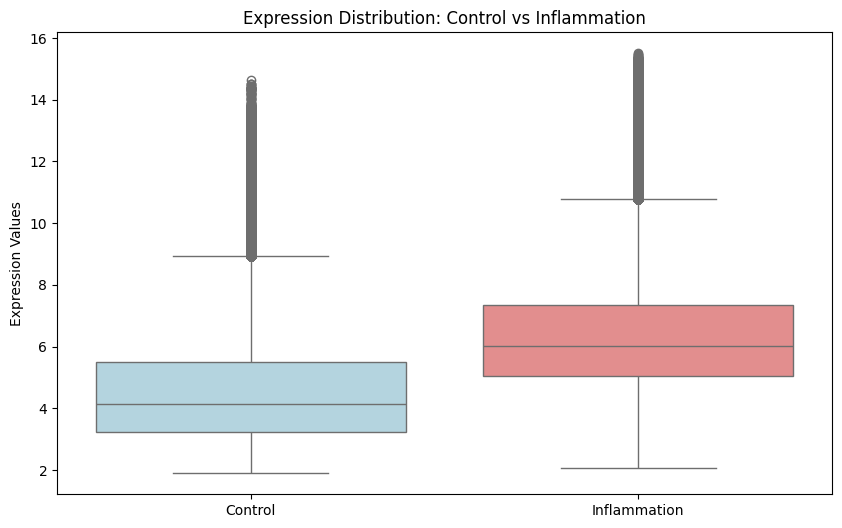

In [20]:
# plot a boxplot of the expression values for group 'control' vs 'inflammation'

import matplotlib.pyplot as plt
import seaborn as sns

# split the adata into control and inflammation groups using pheno_df
control_samples = pheno_df[pheno_df['group'] == 'control'].index
inflammation_samples = pheno_df[pheno_df['group'] == 'inflammation'].index

plt.figure(figsize=(10, 6))
sns.boxplot(data=[exprs_df[control_samples].values.flatten(), exprs_df[inflammation_samples].values.flatten()], 
            palette=["lightblue", "lightcoral"])
plt.xticks([0, 1], ['Control', 'Inflammation'])
plt.ylabel('Expression Values')
plt.title('Expression Distribution: Control vs Inflammation')
plt.show()

In [17]:
human_trauma_adata = create_anndata(exprs_df, pheno_df, species="human")

human_trauma_adata.write_h5ad(f"{OUTPUT_DIR}/human_trauma.h5ad")

Input sequence provided is already in string format. No operation performed


Querying MyGene.info for 17086 genes...


248 input query terms found no hit:	['100127972', '100128175', '100128185', '100128198', '100128298', '100128329', '100128644', '1001287


Query complete.


#### Human sepsis

In [18]:
gsm = list(gses[GSE_IDs["HumanSepsis"]].gsms.values())[-1]
pprint(gsm.metadata)

{'channel_count': ['1'],
 'characteristics_ch1': ['tissue: whole blood', 'health status: POST_SURGICAL'],
 'contact_address': ['Carmody Road'],
 'contact_city': ['Brisbane'],
 'contact_country': ['Australia'],
 'contact_email': ['nscalehome@gmail.com'],
 'contact_institute': ['Queensland Facility for Advanced Bioinformatics'],
 'contact_name': ['Gareth,,Price'],
 'contact_phone': ['61413289611'],
 'contact_state': ['Queensland'],
 'contact_zip/postal_code': ['4072'],
 'data_processing': ['CHP files were generated using a combination of '
                     'Affymetrix Power Tools, R and Perl scripts to filter '
                     'background noise and normalise data based on a detection '
                     'metric used to identify perfect match probes relative to '
                     'other background probes. Differentially expressed genes '
                     'were compared if the signal was >100 and the fold change '
                     'was >2.0.'],
 'data_row_count': ['

In [19]:
gse_obj = gses[GSE_IDs["HumanSepsis"]]

exprs_df = process_geo_to_entrez(gse_obj)

# Prepare the phenotype data
pheno_df = gse_obj.phenotype_data[['characteristics_ch1.0.tissue', 'characteristics_ch1.1.health status']]
pheno_df.columns = ['tissue', 'group']

# Clean up the 'group' column, mapping Sepsis and Healthy
pheno_df['group'] = pheno_df['group'].str.lower()

/tmp/ipykernel_741695/1731019922.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['group'] = pheno_df['group'].str.lower()


In [20]:
# create anndata object
human_sepsis_adata = create_anndata(exprs_df, pheno_df, species="human")

# save anndata object
human_sepsis_adata.write_h5ad(f"{OUTPUT_DIR}/human_sepsis.h5ad")

Input sequence provided is already in string format. No operation performed


Querying MyGene.info for 15637 genes...


292 input query terms found no hit:	['100127972', '100128046', '100128198', '100128343', '100128644', '100128751', '100129069', '1001291


Query complete.


#### Mouse burn and trauma

Both are under the same series, burn is considered "Burn Blood", and trauma is considered "Trauma Heamhorrhage Spleen".

In [13]:
gsm = list(gses[GSE_IDs["MouseBurn"]].gsms.values())[-1]
pprint(gsm.metadata)

{'channel_count': ['1'],
 'characteristics_ch1': ['treatment: LPS treated',
                         'genetic background: C57BL/6J',
                         'cell type: leukocytes',
                         'time: 2 hours'],
 'contact_address': ['55 Fruit Street, GRV 1302'],
 'contact_city': ['Boston'],
 'contact_country': ['USA'],
 'contact_department': ['Department of Surgery'],
 'contact_email': ['data_curator@gluegrant.org'],
 'contact_institute': ['Massachusetts General Hospital'],
 'contact_laboratory': ['Burn & Trauma Research'],
 'contact_name': ['Wenzhong Xiao,,,Inflammation & the Host Response to Injury'],
 'contact_phone': ['617 726 0082'],
 'contact_state': ['MA'],
 'contact_zip/postal_code': ['02114'],
 'data_processing': ['The data were analyzed with Microarray Suite version 5.0 '
                     '(MAS 5.0/GCOS 1.4 ) using Affymetrix default analysis '
                     'settings and global scaling as normalization method.'],
 'data_row_count': ['45101'],
 'descr

In [14]:
gsm = list(gses[GSE_IDs["MouseTrauma"]].gsms.values())[-1]
pprint(gsm.metadata)

{'channel_count': ['1'],
 'characteristics_ch1': ['treatment: LPS treated',
                         'genetic background: C57BL/6J',
                         'cell type: leukocytes',
                         'time: 2 hours'],
 'contact_address': ['55 Fruit Street, GRV 1302'],
 'contact_city': ['Boston'],
 'contact_country': ['USA'],
 'contact_department': ['Department of Surgery'],
 'contact_email': ['data_curator@gluegrant.org'],
 'contact_institute': ['Massachusetts General Hospital'],
 'contact_laboratory': ['Burn & Trauma Research'],
 'contact_name': ['Wenzhong Xiao,,,Inflammation & the Host Response to Injury'],
 'contact_phone': ['617 726 0082'],
 'contact_state': ['MA'],
 'contact_zip/postal_code': ['02114'],
 'data_processing': ['The data were analyzed with Microarray Suite version 5.0 '
                     '(MAS 5.0/GCOS 1.4 ) using Affymetrix default analysis '
                     'settings and global scaling as normalization method.'],
 'data_row_count': ['45101'],
 'descr

In [19]:
gse_obj = gses[GSE_IDs["MouseBurn"]]

# 1. Prepare the expression matrix
exprs_df = process_geo_to_entrez(gse_obj)

# 2. Prepare the phenotype data
pheno_df = gse_obj.phenotype_data[['title']]

# Create boolean masks for each specific group
is_burn_blood = pheno_df['title'].str.contains('Burn Blood', case=False)
is_burn_sham_blood = pheno_df['title'].str.contains('Burn Sham Blood', case=False)
is_trauma_spleen = pheno_df['title'].str.contains('Trauma Hemorrhage Spleen', case=False)
is_trauma_sham_spleen = pheno_df['title'].str.contains('Trauma Hemorrhage Sham Spleen', case=False)

# Assign study and group based on the masks
pheno_df['study'] = 'Unknown'
pheno_df.loc[is_burn_blood | is_burn_sham_blood, 'study'] = 'Burn'
pheno_df.loc[is_trauma_spleen | is_trauma_sham_spleen, 'study'] = 'Trauma'

pheno_df['group'] = 'Unknown'
pheno_df.loc[is_burn_blood, 'group'] = 'inflammation'
pheno_df.loc[is_trauma_spleen, 'group'] = 'inflammation'
pheno_df.loc[is_burn_sham_blood, 'group'] = 'control'
pheno_df.loc[is_trauma_sham_spleen, 'group'] = 'control'

# Extract time point and convert to hours
pheno_df['time_point'] = pheno_df['title'].str.extract(r'(\d+ day|\d+ hr)', expand=False)
pheno_df['time_point'] = pheno_df['time_point'].str.replace('hr', '').str.replace('day', '').astype(float)
pheno_df.loc[pheno_df['title'].str.contains('day'), 'time_point'] *= 24
pheno_df['time_point'] = pheno_df['time_point'].fillna(0) # Assign 0 to controls

# Filter out any unclassified samples (LPS, etc.)
pheno_df_filtered = pheno_df[pheno_df['study'] != 'Unknown']

# 3. Split into two separate datasets
burn_samples = pheno_df_filtered[pheno_df_filtered['study'] == 'Burn'].index
trauma_samples = pheno_df_filtered[pheno_df_filtered['study'] == 'Trauma'].index

# log2 transform the expression data
exprs_df = np.log2(exprs_df + 1)

mouse_burn_processed = {
    'expression': exprs_df[burn_samples],
    'phenotype': pheno_df_filtered.loc[burn_samples]
}

mouse_trauma_processed = {
    'expression': exprs_df[trauma_samples],
    'phenotype': pheno_df_filtered.loc[trauma_samples]
}

/tmp/ipykernel_742984/2947477079.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['study'] = 'Unknown'
/tmp/ipykernel_742984/2947477079.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['group'] = 'Unknown'
/tmp/ipykernel_742984/2947477079.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [21]:
# create and save anndata objects
mouse_burn_adata = create_anndata(mouse_burn_processed['expression'], mouse_burn_processed['phenotype'], species="mouse")
mouse_trauma_adata = create_anndata(mouse_trauma_processed['expression'], mouse_trauma_processed['phenotype'], species="mouse")

# save annData objects
mouse_burn_adata.write_h5ad(f"{OUTPUT_DIR}/mouse_burn.h5ad")
mouse_trauma_adata.write_h5ad(f"{OUTPUT_DIR}/mouse_trauma.h5ad")

Input sequence provided is already in string format. No operation performed


Querying MyGene.info for 20770 genes...


321 input query terms found no hit:	['100036528', '100038480', '100039280', '100040465', '100041064', '100041799', '100041960', '1000421
Input sequence provided is already in string format. No operation performed


Query complete.
Querying MyGene.info for 20770 genes...


321 input query terms found no hit:	['100036528', '100038480', '100039280', '100040465', '100041064', '100041799', '100041960', '1000421


Query complete.


#### Mouse sepsis

In [25]:
gsm = list(gses[GSE_IDs["MouseSepsis"]].gsms.values())[-1]
pprint(gsm.metadata)

{'channel_count': ['1'],
 'characteristics_ch1': ['strain: C57BL/6J',
                         'infection: Staphylococcus aureus',
                         'time point: 12 hours'],
 'contact_address': ['2424 Erwin Road'],
 'contact_city': ['Durham'],
 'contact_country': ['USA'],
 'contact_email': ['lgcowell@duke.edu'],
 'contact_institute': ['Duke University'],
 'contact_name': ['Lindsay,,Cowell'],
 'contact_state': ['NC'],
 'contact_zip/postal_code': ['27705'],
 'data_processing': ['Preprocessing was conducted using the Robust Multichip '
                     'Analysis (RMA) (PMID: 12925520) implementation in the '
                     'Bioconductor “affy” package '
                     '(http://www.bioconductor.org/), with an additional step '
                     'to account for differences in probe hybridization '
                     'resulting from single nucleotide polymorphisms (SNP) '
                     'between A/J and C57BL/6J mice.  The additional step is '
              

In [26]:
gse_obj = gses[GSE_IDs["MouseSepsis"]]

# 1. Prepare the expression matrix
exprs_df = process_geo_to_entrez(gse_obj)

# 2. Prepare the phenotype data
pheno_df = gse_obj.phenotype_data[['characteristics_ch1.0.strain', 'characteristics_ch1.1.infection', 'characteristics_ch1.2.time point']]
pheno_df.columns = ['strain', 'infection', 'time_point']

# Clean up and standardize the 'time_point' column
pheno_df['time_point'] = pheno_df['time_point'].str.extract(r'(\d+)', expand=False).astype(float)
pheno_df['time_point'] = pheno_df['time_point'].fillna(0)

/tmp/ipykernel_741695/3805000939.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['time_point'] = pheno_df['time_point'].str.extract(r'(\d+)', expand=False).astype(float)
/tmp/ipykernel_741695/3805000939.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_df['time_point'] = pheno_df['time_point'].fillna(0)


In [27]:
# create anndata object
mouse_sepsis_adata = create_anndata(exprs_df, pheno_df, species="mouse")

# save anndata object
mouse_sepsis_adata.write_h5ad(f"{OUTPUT_DIR}/mouse_sepsis.h5ad")

Input sequence provided is already in string format. No operation performed


Querying MyGene.info for 18238 genes...


241 input query terms found no hit:	['100039280', '100040465', '100041064', '100041799', '100041960', '100042192', '100042464', '1000489


Query complete.


#### Mouse infection

In [28]:
gsm = list(gses[GSE_IDs["MouseInfection"]].gsms.values())[-15]
pprint(gsm.metadata)

{'channel_count': ['1'],
 'characteristics_ch1': ['cohort: C.albicans Signature  Validation Cohort',
                         'tissue: Whole Blood',
                         'genotype: BALB/c',
                         'age: 8 wk old',
                         'infection status: candida',
                         'infection duration (days): 3'],
 'contact_address': ['101 Science Drive'],
 'contact_city': ['Durham'],
 'contact_country': ['USA'],
 'contact_department': ['Institute of Genomic Science and Policy'],
 'contact_email': ['ha2@duke.edu'],
 'contact_institute': ['Duke University'],
 'contact_laboratory': ['Geoffrey Ginsburg'],
 'contact_name': ['Hamza,,Aziz'],
 'contact_state': ['NC'],
 'contact_zip/postal_code': ['27708'],
 'data_processing': ['Expression Console (Affymetrix, Santa Clara, CA) was '
                     'used to ensure that microarray data intensity files met '
                     'quality control parameters.  Next, expression data from '
                     '

In [29]:
gse_obj = gses[GSE_IDs["MouseInfection"]]

# Prepare the expression matrix
exprs_df = process_geo_to_entrez(gse_obj)

# Prepare the phenotype data
pheno_df = gse_obj.phenotype_data[[
    'characteristics_ch1.0.cohort',
    'characteristics_ch1.1.tissue',
    'characteristics_ch1.2.genotype',
    'characteristics_ch1.3.age',
    'characteristics_ch1.4.infection status',
    'characteristics_ch1.5.infection duration (days)'
]]
pheno_df.columns = ['cohort', 'tissue', 'genotype', 'age', 'infection_status', 'time_point']

# Explicitly filter for 'healthy' and 'C.albicans' status
is_healthy = pheno_df['infection_status'].str.lower().str.contains('healthy')
is_candida = pheno_df['infection_status'].str.lower().str.contains('candida')

# Filter the DataFrame to include only these two conditions
pheno_df_filtered = pheno_df[is_healthy | is_candida].copy()

# Clean up and standardize the 'time_point' column (in days)
pheno_df_filtered['time_point'] = pheno_df_filtered['time_point'].astype(float)
pheno_df_filtered['time_point'] = pheno_df_filtered['time_point'].fillna(0)

# convert time_point from days to hours
pheno_df_filtered['time_point'] = pheno_df_filtered['time_point'] * 24

# Filter expression data to match the filtered phenotype data
exprs_df_filtered = exprs_df.loc[:, pheno_df_filtered.index]

In [30]:
# create anndata object
mouse_infection_adata = create_anndata(exprs_df_filtered, pheno_df_filtered, species="mouse")

# save anndata object
mouse_infection_adata.write_h5ad(f"{OUTPUT_DIR}/mouse_infection.h5ad")

Input sequence provided is already in string format. No operation performed


Querying MyGene.info for 10411 genes...


24 input query terms found no hit:	['100039280', '100303734', '100379603', '100379605', '100379611', '100502987', '100503499', '1005042


Query complete.
